# Criminal Recidivism Subgroup Discovery

## Setup

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
import pysubgroup as ps

In [2]:
data_path = "36404-0001-Data.tsv"

## Get Data

In [3]:
def render_table(table, title):
  print(pd.Series(table).to_frame(title))

In [4]:
def parse_id(id):
  return np.int64(id[1:])

In [5]:

index = 'ABT_INMATE_ID'

columns = {
  'SEX': 'uint8',
  'ADMTYPE': 'Int8',
  'OFFGENERAL': 'Int8',
  'SENTLGTH': 'Int8',
  'RACE': 'Int8',
  'AGEADMIT': 'Int8',
  'TIMESRVD': 'Int8',
  'RELTYPE' : 'Int8',
  'ADMITYR' : 'Int16'
}

In [6]:
missing_values = {
  'ADMTYPE': '9',             # 9 = missing.
  'OFFGENERAL': [ '9' ],      # 9 = missing.
  'ADMITYR': '9999',          # 9999 = missing.
  'RELEASEYR': '9999',        # 9999 = missing.
  'SENTLGTH': ['9', ' '],     # 9 = missing.
  'RACE': '9',                # 9 = missing.
  'AGEADMIT': '9',            # 9 = missing.
  'TIMESRVD': '9',            # 9 = missing.
  'RELTYPE': ' '              # 9 = missing.
}

In [7]:
nrows = 4_000_000

In [8]:
data = pd.read_csv(
  'full.tsv',
  sep = '\t',
  usecols = [ index ] + list(columns),
  dtype = columns,
  na_values = missing_values,
  converters = { index: parse_id }
)

## Plot null 

In [9]:
missing_data = data.isnull().mean()

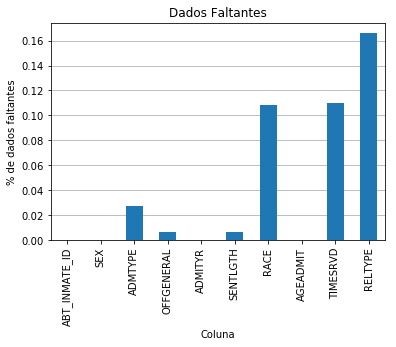

In [10]:
ax = missing_data.plot(
  kind = 'bar',
  title = 'Dados Faltantes',
  zorder = 2 # bars over grid
)

ax.set(
  xlabel = 'Coluna',
  ylabel = '% de dados faltantes'
)

ax.yaxis.grid();

## Set Target and Drop Null Columns

In [11]:
target = 'RECIDIVIST'

In [12]:
len(data)

10907333

In [13]:
data_sorted = data.sort_values(by = ['ADMITYR'])

data = data_sorted.assign(
  **{
    target: data_sorted.duplicated(
      subset = index,
      keep = 'last'
    )
  }
)

In [14]:
data = data.drop('ADMITYR', axis = 1);


In [15]:
data_drop = data.dropna()

In [16]:
data.columns

Index(['ABT_INMATE_ID', 'SEX', 'ADMTYPE', 'OFFGENERAL', 'SENTLGTH', 'RACE',
       'AGEADMIT', 'TIMESRVD', 'RELTYPE', 'RECIDIVIST'],
      dtype='object')

In [17]:
data_drop.shape

(7962136, 10)

In [18]:
data[target].value_counts(normalize = True)


False    0.561635
True     0.438365
Name: RECIDIVIST, dtype: float64

## Set Considered Features

In [19]:
features = {
  'SEX',
  'ADMTYPE',
  'OFFGENERAL',
  'SENTLGTH',
  'RACE',
  'AGEADMIT',
  'TIMESRVD',
  'RELTYPE',
  
}

disconsidered_features = [
  index
]

In [20]:
data = data.drop(disconsidered_features, axis = 1);


In [21]:
data_frame = data

In [22]:
data_frame

,SEX,ADMTYPE,OFFGENERAL,SENTLGTH,RACE,AGEADMIT,TIMESRVD,RELTYPE,RECIDIVIST
4019778,1,1,1,6,1,2,4,1,False
4564668,1,1,1,0,2,1,<NA>,<NA>,False
4514239,1,1,1,4,2,2,<NA>,<NA>,False
3991764,1,1,1,6,2,1,4,1,True
3985767,1,1,2,0,2,3,<NA>,<NA>,False
...,...,...,...,...,...,...,...,...,...
9025226,1,1,1,<NA>,2,1,<NA>,<NA>,False
9047003,1,1,1,4,1,1,4,1,False
9210430,1,1,3,4,2,1,<NA>,<NA>,False
10694870,1,1,2,4,1,1,4,1,False


## Subgroup Discovery

In [23]:
for feature in features:
    ohe = pd.get_dummies(data_frame[feature], prefix=feature)
    data_frame = data_frame.drop(feature, axis=1)
    data_frame = pd.concat([data_frame, ohe], axis=1)



In [24]:
target = ps.BinaryTarget ('RECIDIVIST', True)
searchspace = ps.create_selectors(data_frame, ignore=['RECIDIVIST'])

task = ps.SubgroupDiscoveryTask (
    data_frame,
    target,
    searchspace,
    result_set_size=20,
    depth=5,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)


In [29]:
data_frame.shape

(10907333, 35)

In [25]:
res = result.to_dataframe()

In [30]:
data_frame

,RECIDIVIST,OFFGENERAL_1,OFFGENERAL_2,OFFGENERAL_3,OFFGENERAL_4,OFFGENERAL_5,ADMTYPE_1,ADMTYPE_2,ADMTYPE_3,SENTLGTH_0,...,AGEADMIT_3,AGEADMIT_4,AGEADMIT_5,RELTYPE_1,RELTYPE_2,RELTYPE_3,RACE_1,RACE_2,RACE_3,RACE_4
4019778,False,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4564668,False,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4514239,False,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3991764,True,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3985767,False,0,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025226,False,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9047003,False,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
9210430,False,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10694870,False,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [26]:
res

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.062709,AGEADMIT_5==0 AND RELTYPE_1==1 AND SENTLGTH_6=...,6045190.0,10907333.0,3333982.0,4781392.0,4862143.0,0.554232,0.445768,0.697283,0.302717,0.551510,0.297690,0.438365,1.258107
1,0.062669,AGEADMIT_5==0 AND RELTYPE_1==1 AND TIMESRVD_3=...,6062152.0,10907333.0,3340991.0,4781392.0,4845181.0,0.555787,0.444213,0.698749,0.301251,0.551123,0.297285,0.438365,1.257224
2,0.062669,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_3==...,6062152.0,10907333.0,3340991.0,4781392.0,4845181.0,0.555787,0.444213,0.698749,0.301251,0.551123,0.297285,0.438365,1.257224
3,0.062669,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_2==...,6062152.0,10907333.0,3340991.0,4781392.0,4845181.0,0.555787,0.444213,0.698749,0.301251,0.551123,0.297285,0.438365,1.257224
4,0.062291,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_2==...,6351782.0,10907333.0,3463825.0,4781392.0,4555551.0,0.582341,0.417659,0.724439,0.275561,0.545331,0.289222,0.438365,1.244012
5,0.062291,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_3==...,6351782.0,10907333.0,3463825.0,4781392.0,4555551.0,0.582341,0.417659,0.724439,0.275561,0.545331,0.289222,0.438365,1.244012
6,0.062291,AGEADMIT_5==0 AND RELTYPE_1==1 AND SENTLGTH_6=...,6351782.0,10907333.0,3463825.0,4781392.0,4555551.0,0.582341,0.417659,0.724439,0.275561,0.545331,0.289222,0.438365,1.244012
7,0.062193,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_2==...,6375355.0,10907333.0,3473096.0,4781392.0,4531978.0,0.584502,0.415498,0.726378,0.273622,0.544769,0.288681,0.438365,1.242730
8,0.062193,AGEADMIT_5==0 AND RELTYPE_1==1 AND TIMESRVD_4==0,6375355.0,10907333.0,3473096.0,4781392.0,4531978.0,0.584502,0.415498,0.726378,0.273622,0.544769,0.288681,0.438365,1.242730
9,0.062193,AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_3==...,6375355.0,10907333.0,3473096.0,4781392.0,4531978.0,0.584502,0.415498,0.726378,0.273622,0.544769,0.288681,0.438365,1.242730


In [30]:
res['subgroup'].iloc[4]

'AGEADMIT_5==0 AND RELTYPE_1==1 AND RELTYPE_2==0 AND SENTLGTH_6==0 AND TIMESRVD_4==0'

## Table with Results

| Tamanho | Subgrupo |
| --- | ----------- |
| 2| Condicional && TempoS < 10 anos
| 2| Condicional && Revogou Condicional
| 2| Condicional && Ofensa Especificada
| 3| Id < 55 && Condicional && Raça != outros
| 3| Id < 55 && Condicional && TempoS < 5
| 4| Id < 55 && Condicional && TempoS < 10 && Homem
| 4| Id < 55 && Condicional && TempoS < 10&& Sentença != perpétua